In [1]:

import os
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torchvision import transforms
from captum.robust import PGD

# from model import vit_base_patch16_224
from timm.models import vit_base_patch16_224
import sys
sys.path.append('../')
from saliency import *
from utils import *
from plots import *

In [2]:
# model = vit_base_patch16_224(pretrained=True)
model = torch.load('/home/raza.imam/Documents/HC701B/Project/models/vit_base_patch16_224_in21k_test-accuracy_0.96_chest.pth')
model = model.cuda()

In [3]:
model.blocks[11].attn

Attention(
  (qkv): Linear(in_features=768, out_features=2304, bias=True)
  (attn_drop): Dropout(p=0.0, inplace=False)
  (proj): Linear(in_features=768, out_features=768, bias=True)
  (proj_drop): Dropout(p=0.0, inplace=False)
)

# 1. For 1 image sample

In [4]:
image_folder = "/home/raza.imam/Documents/HC701B/Project/data/TB_data/testing/Tuberculosis/"
block = 11
plot=False
rand=False
random_state=None

img, attn_cln, attn_adv, att_diff = test_img_attn(image_folder, block, model, plot=plot, rand=rand, random_state=random_state)

/home/raza.imam/.conda/envs/xaim/lib/python3.7/site-packages/captum/_utils/gradient.py:59: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index


torch.Size([224, 224, 3])
(224, 224)
(224, 224)


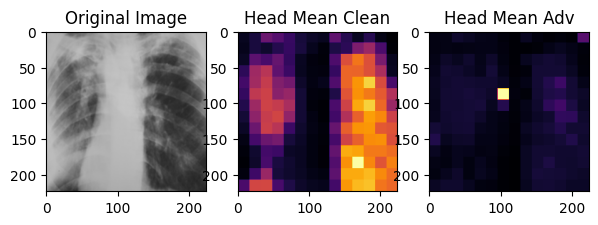

In [5]:
plt.figure(figsize=(7, 7))
text = ["Original Image", "Head Mean Clean", "Head Mean Adv"]
for i, fig in enumerate([img.squeeze(0).permute(2,1,0), attn_cln, attn_adv]):
    print(fig.shape)
    plt.subplot(1, 3, i+1)
    plt.imshow(fig, cmap='inferno')
    plt.title(text[i])
plt.show()

# 2. Mean Attention of a block. For n images. 

In [6]:
from saliency import mean_attns_N_images
image_folder = "/home/raza.imam/Documents/HC701B/Project/data/TB_data/training/Tuberculosis/"
block = 11 #Select range from 0 to 11
N_images = 100
N_random = False
device = "cuda"

print(f"On Block {block}")
mean_attns_cln, mean_attns_adv, mean_attns_diff, attentions_clean, attentions_adv = mean_attns_N_images(image_folder=image_folder, N_images=N_images, 
                                                                      block=block, model=model, N_random=N_random, device=device)


On Block 11
torch.Size([100, 3, 224, 224])
mean_attns_cln.shape: (224, 224)
mean_attns_adv.shape: (224, 224)
mean_attns_diff.shape: (224, 224)


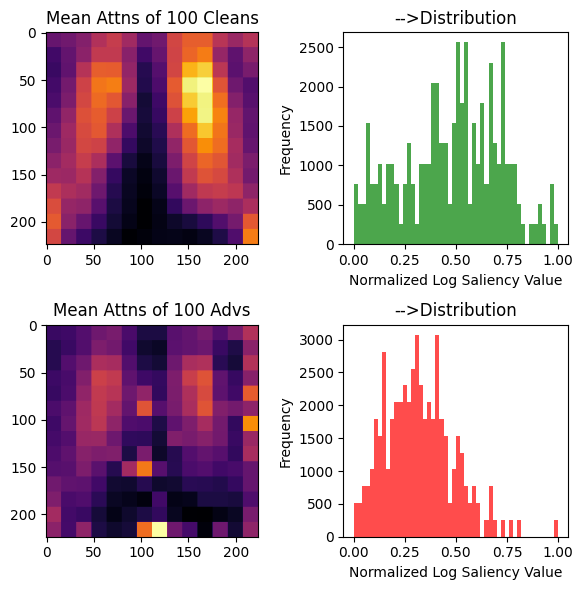

In [7]:
hist_plot(mean_attns_cln, mean_attns_adv, N_images)

# 3. Compare 1 test sample with 1000 clean and adv means

In [8]:
# #Calculating 1000 images mean attn
# from saliency import mean_attns_N_images
# image_folder = "/home/raza.imam/Documents/HC701B/Project/data/TB_data/training/Tuberculosis/"
# block = 11 #Select range from 0 to 11
# N_images = 1000
# N_random = False
# device = "cuda"

# print(f"On Block {block}")
# mean_attns_cln, mean_attns_adv, mean_attns_diff, attentions_clean, attentions_adv = mean_attns_N_images(image_folder=image_folder, N_images=N_images, 
#                                                                       block=block, model=model, N_random=N_random, device=device)
# hist_plot(mean_attns_cln, mean_attns_adv, N_images)

In [9]:
# # Calculating 1 test image attn
# image_folder = "/home/raza.imam/Documents/HC701B/Project/data/TB_data/testing/Tuberculosis/"
# block = 11
# plot=False
# rand=False
# random_state=None

# img, attn_cln, attn_adv, att_diff = test_img_attn(image_folder, block, model, plot=plot, rand=rand, random_state=random_state)

# plt.figure(figsize=(7, 7))
# text = ["Original Image", "Head Mean Clean", "Head Mean Adv"]
# for i, fig in enumerate([img.squeeze(0).permute(2,1,0), attn_cln, attn_adv]):
#     print(fig.shape)
#     plt.subplot(1, 3, i+1)
#     plt.imshow(fig, cmap='inferno')
#     plt.title(text[i])
# plt.show()

In [11]:
#Testing
def sum_metric(saliency_test_img, mean_saliency_normal, mean_saliency_adv):
    del_N = (mean_saliency_normal-saliency_test_img)
    del_A = (mean_saliency_adv-saliency_test_img)

    sum_N = np.sum(del_N)
    sum_A = np.sum(del_A)

    return sum_N, sum_A

print("When attn_cln is compared with mean attns:")
sum_N, sum_Adv = sum_metric(attn_adv, mean_attns_cln, mean_attns_adv)
print(f"sum_del_N: {sum_N}", f"sum_del_A: {sum_Adv}")
if sum_N <= sum_Adv:
    pred = "Normal"
else:
    pred = "Adversarial"
print(f"Prediction: {pred}\n")

When attn_cln is compared with mean attns:
sum_del_N: -6.447484493255615 sum_del_A: -4.114640712738037
Prediction: Normal

